## **Overview**

We will be working with the [Gluon dataset](https://github.com/rabah-khalek/TF_tutorials/tree/master/PseudoData). A gluon is an elementary particle which gives rise to the strong force, which is the force responsible for binding together the protons and neutrons together in atomic nuclei.

The gluon is exchanged by other elementary particles in the proton and neutron called quarks. These quarks and gluons are more generally referred to as "partons".

Because of certain physical properties governing the partons, they cannot be observed by expermiments as free particles, and their distribution within the proton and neutron cannot be calculated analytically. Instead, their distribution must be inferred from data collected by high energy particle colliders like the Large Hadron Collider (LHC) at CERN.

A fast-moving proton can be described by the parton distribution function (PDF) $f(x)$, which gives the probability density of finding a parton of type $f$ (a specific quark type or gluon) carrying a fraction $x$ of the proton momentum.

The pseudodata used in this tutorial is generated from a gluon distribution function $g(x)$, which was determined in an analysis by the [NNPDF collaboration](http://nnpdf.mi.infn.it), aiming to extract the structure of the proton using contemporary machine learning methods. More specifically, NNPDF determines PDFs using neural networks as a minimally biased modeling tool, trained using Genetic Algorithms (and more recently stochastic gradient descent).

We will consider this pseudodata to be the *truth* that we're trying to *discover*. What we will actually fit is the *smeared truth*, where Gaussian noise is added to simulate more realistic data.

## **Importing the Gluon data set with Pandas**

There are four separate datasets each containing a total of 1000 gluon PDF predictions computed between $x=[x_{min},1]$; where:
- $x_{min} = 10^{-3}$ for `filename1`
- $x_{min} = 10^{-4}$ for `filename2`
- $x_{min} = 10^{-5}$ for `filename3`
- $x_{min} = 10^{-6}$ for `filename4`

Below we use Pandas to import all datapoints from text files.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# The datasets needed are computed by the `ComputeGluon.py` script in PseudoData
filename1='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-3.dat'
filename2='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-4.dat'
filename3='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-5.dat'
filename4='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-6.dat'

# Headers to skip
lines_to_skip = 5

# Defining the columns (cv = central value, sd = standard deviation)
columns=["x", "gluon_cv", "gluon_sd"]

# Change filename1 to another filename for data that extends to lower x
# (see exercises at the bottom of this notebook)
df = pd.read_csv(filename1,
                 sep="\s+",
                 skiprows=lines_to_skip,
                 usecols=[0,1,2],
                 names=columns)

# Splitting data randomly to train and test using the sklearn library
df_train, df_test = train_test_split(df,test_size=0.2,random_state=42)

# Sort the split data according to their x values
df_train = df_train.sort_values("x")
df_test = df_test.sort_values("x")



Let us plot what we loaded

In [ ]:
import matplotlib.pyplot as plt

def createTrainTestPlots(train, test):
  """
  plots the data from the train and test sets.

  :param train: Required, dataframe with keys in ["x", "gluon_cv", "gluon_sd"].
  :param test: Required, dataframe with keys in ["x", "gluon_cv", "gluon_sd"].
  """
  fig, ax = plt.subplots(1,2,figsize=(10, 3))
  ax[0].axhline(0,color='k',linewidth=0.5)
  ax[0].errorbar(train['x'], train['x']*train['gluon_cv'], train['gluon_sd'], fmt = '.', color='b', alpha=0.5)
  ax[0].set_title("Train data")
  ax[0].set_xlabel("x")
  ax[0].set_ylabel("g(x)")
  ax[0].set_ylim(-0.05,0.4)
  ax[1].axhline(0,color='k',linewidth=0.5)
  ax[1].errorbar(test['x'], test['x']*test['gluon_cv'], test['gluon_sd'], fmt = '.', color='r', alpha=0.5)
  ax[1].set_title("Test data")
  ax[1].set_xlabel("x")
  ax[1].set_ylabel("g(x)")
  ax[1].set_ylim(-0.05,0.4)
  plt.show()

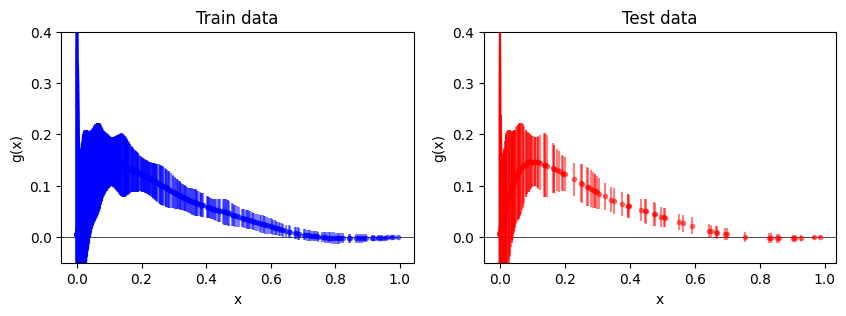

In [ ]:
createTrainTestPlots(df_train, df_test)

Now we have to prepare the data for the training

In [ ]:
# From the dataframe we extract x, gluon and the error on the gluon and cast them to numpy arrays
train_x = df_train['x'].to_numpy()
train_y = df_train['gluon_cv'].to_numpy()
train_dy = df_train['gluon_sd'].to_numpy()

# From the dataframe we extract x, gluon and the error on the gluon and cast them to numpy arrays
test_x = df_test['x'].to_numpy()
test_y = df_test['gluon_cv'].to_numpy()
test_dy = df_test['gluon_sd'].to_numpy()

### Work on one Model

We want to try to build the a model to identify the amplitude, and X and Y coordinates of the shower.

#### Open questions:
1. What batch size?
1. What learning rate?
1. How many layers?
1. How many nodes per layer?
1. etc...


### Let's begin by writing a function:

1. a basic sequential neural network:
  * configurable input dimensions (width)
  * configurable number of nodes per layer
  * configurable activations per layer
  * configurable number of outputs



In [ ]:
# import tensor flow packages
from tensorflow import keras
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
import sys

In [ ]:
# sequential neural network with selected parameters
def create_sequential_dnn(inputs=1, num_nodes=(6,6), activations=('sigmoid','sigmoid'), outputs=1):

  model = Sequential()

  model.add(Flatten())

  if len(num_nodes) != len(activations):
    print('The length of the number of nodes array and activations array must be the same.')
    sys.exit()

  # loop over the number of nodes
  for (i, n) in enumerate(num_nodes):
    if i == 0:
      model.add(Dense(n, activation=activations[i], input_dim=inputs))
    else:
      model.add(Dense(n, activation=activations[i]))

  # output
  model.add(Dense(outputs, activation="linear"))

  # return the CNN
  return model

Create and compile the model

In [ ]:
model = create_sequential_dnn()
  # Adam optimizer
lr = 0.1
opt = Adam(learning_rate=lr)
# Define chisquare2 loss function

model.compile(loss="mse", optimizer=opt)

Start the fit

In [ ]:
# sequential network - feel free to add elements
history = model.fit(x=train_x,
                    y=train_y,
                    validation_data=(test_x, test_y),
                    epochs=120,
                    batch_size=10)

Epoch 1/120
80/80 [==============================] - 1s 4ms/step - loss: 1.7547 - val_loss: 0.0896
Epoch 2/120
80/80 [==============================] - 0s 3ms/step - loss: 0.1005 - val_loss: 0.0384
Epoch 3/120
80/80 [==============================] - 0s 3ms/step - loss: 0.0490 - val_loss: 0.0386
Epoch 4/120
80/80 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0558
Epoch 5/120
80/80 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0185
Epoch 6/120
80/80 [==============================] - 0s 3ms/step - loss: 0.0379 - val_loss: 0.0198
Epoch 7/120
80/80 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0224
Epoch 8/120
80/80 [==============================] - 0s 2ms/step - loss: 0.0206 - val_loss: 0.0142
Epoch 9/120
80/80 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0204
Epoch 10/120
80/80 [==============================] - 0s 2ms/step - loss: 0.0162 - val_loss: 0.0170
Epoch 11/

Let us see how predictions worked

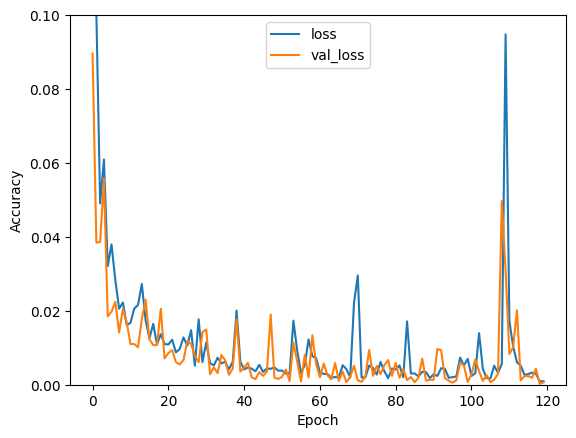

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0., 0.1])
plt.legend(loc='best')

Let us see if we can now predict something

In [ ]:
x_pred = df['x'].to_numpy()
y_pred = model.predict(x_pred)

32/32 [==============================] - 0s 1ms/step


In [ ]:
def createTrainPredictPlots(train, test):
  """
  plots the data from the train and test sets.

  :param train: Required, dataframe with keys in ["x", "gluon_cv", "gluon_sd"].
  :param test: Required, dataframe with keys in ["x", "gluon_cv", "gluon_sd"].
  """
  fig, ax = plt.subplots(1,2,figsize=(10, 3))
  #Train data
  ax[0].axhline(0,color='k',linewidth=0.5)
  ax[0].errorbar(train['x'], train['x']*train['gluon_cv'], train['gluon_sd'], fmt = '.', color='b', alpha=0.5)
  ax[0].set_title("Train and test data")
  ax[0].set_xlabel("x")
  ax[0].set_ylabel("x g(x)")
  #Test data
  ax[0].errorbar(test['x'], test['x']*test['gluon_cv'], test['gluon_sd'], fmt = '.', color='r', alpha=0.5)
  ax[0].set_ylim(-0.05,0.4)
  # Predictions
  x_pred = train['x'].to_numpy()
  x_pred.sort()
  y_pred = model.predict(x_pred)

  # This is weird, but this is how I create x*g(x) as both of them are arrays
  xy_pred = []
  for _ in range(len(x_pred)):
    xy_pred.append(x_pred[_]*y_pred[_])
  ax[0].plot(x_pred, xy_pred, color='g', linewidth = 3.5)

  # Just predictions
  ax[1].axhline(0,color='k',linewidth = 0.5)
  ax[1].plot(x_pred, xy_pred, color='g', alpha=0.5)
  ax[1].set_title("Predictions")
  ax[1].set_xlabel("x")
  ax[1].set_ylabel("x g(x)")
  plt.show()

25/25 [==============================] - 0s 2ms/step


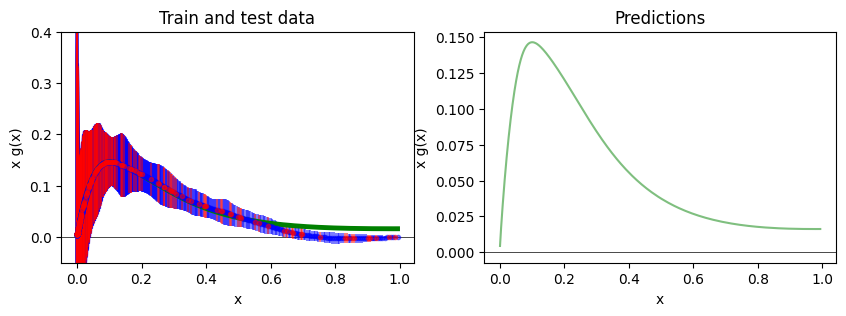

In [ ]:
createTrainPredictPlots(df_train, df_test)



---

